# Выполнил:
# Радайкин Артём, ПМ20-4 

## Загружаем данные

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
import scipy.stats as sts
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
pd.set_option('display.max_columns' , None)
from plotly.subplots import make_subplots

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Эконометрика /ДТЗ/ds_salaries.csv')
df.drop(['Unnamed: 0', 'salary',	'salary_currency'], axis=1, inplace=True)
df.head(5)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Описание данных:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


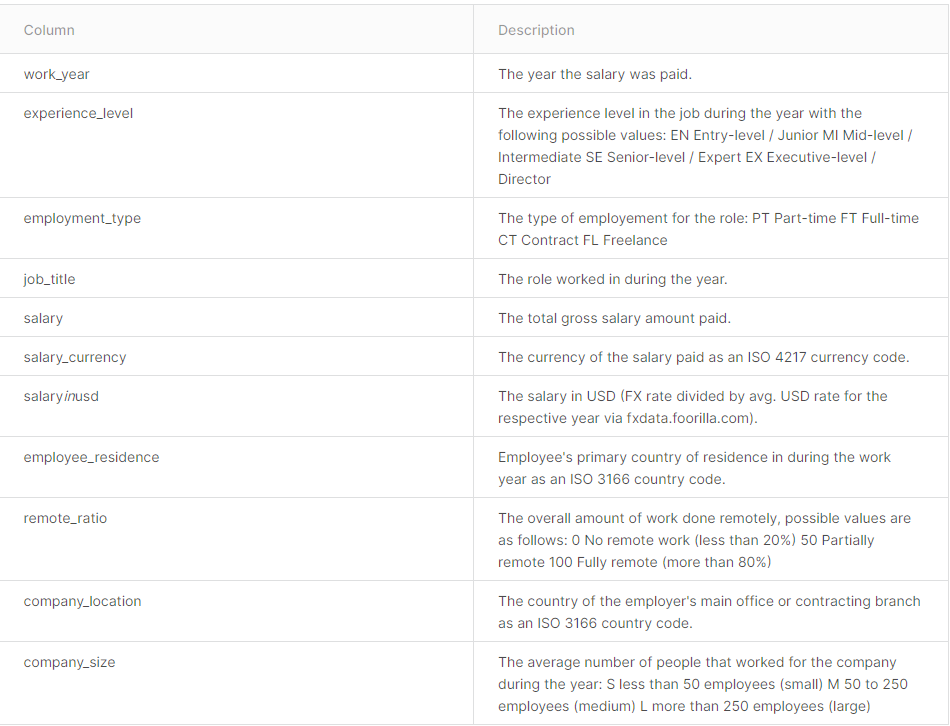

### Распределение зарплаты 


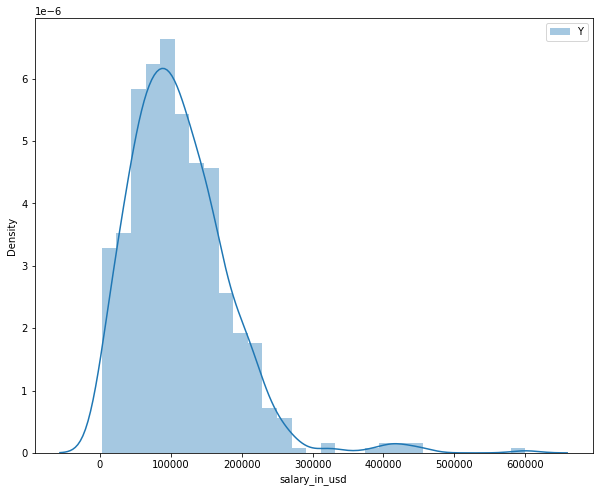

In [ ]:
# Распределение зарплаты
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['salary_in_usd'], ax=ax, label='Y').legend();
# px.histogram(df, x = 'salary_in_usd' , template = 'ggplot2' , labels = {'salary_in_usd' : 'salary'} , title = '<b> Распределение зарплаты в USD')

In [ ]:
px.box(df, x = 'salary_in_usd' , template = 'ggplot2' , labels = 'salary_in_usd' , title = '<b> Распределение зарплаты в USD')

In [ ]:
df = df[(df.salary_in_usd < 500_000)]

In [ ]:
# Популярные Data Science направления
z = df['job_title'].value_counts().head(10)
fig = px.bar(z , x=z.index , y = z.values , color = z.index , text = z.values , labels = {'index':'job_title' , 'y':'count' , 'text':'count'}
            ,template = 'seaborn' , title = '<b>Top 10 Популярных Data Science направлений')
fig.show()

In [ ]:
# Наиболее оплачиваемые направления в Data science
fig = px.bar(df.groupby('job_title' , as_index = False)['salary_in_usd'].max().sort_values(by = 'salary_in_usd' , ascending = False).head(10),
            x = 'job_title' , y = 'salary_in_usd' , color = 'job_title' , labels = {'job_title' : 'job title' , 'salary_in_usd': 'salary in usd'},
        template = 'ggplot2' , text = 'salary_in_usd' , title = '<b>Top 10 оплачиваемых направлений в Data Science')
fig.show()

На приведенной выше гистограмме мы видим, что аналитик финансовых данных зарабатывает до 450 тысяч долларов США в год, что является поразительной суммой. Если мы говорим о других 8 ролях, то максимальная зарплата превышает 300 тысяч, что опять же очень хорошая зарплата для работы.

In [ ]:
z = df.groupby('job_title' , as_index = False)['salary_in_usd'].mean().sort_values(by = 'salary_in_usd' , ascending = False)
z['salary_in_usd'] = round(z['salary_in_usd'] , 2)
fig = px.bar(z.head(10) , x = 'job_title' , y = 'salary_in_usd' , color = 'job_title' , labels = {'job_title': 'job title' , 'salary_in_usd' :'avg salary in usd'},
            text = 'salary_in_usd', template = 'seaborn' , title = '<b>Top 10 направлений в Data Science по среднему показателю з/п')
fig.update_traces(textfont_size = 8)
fig.show()

### Строим регрессионную модель:

In [ ]:
df['job_title'] = df.job_title.map(lambda x: x.replace(' ','_'))

In [ ]:
df_1 = pd.get_dummies(df)

In [ ]:
' + '.join(df_1.columns) 

'work_year + salary_in_usd + remote_ratio + experience_level_EN + experience_level_EX + experience_level_MI + experience_level_SE + employment_type_CT + employment_type_FL + employment_type_FT + employment_type_PT + job_title_3D_Computer_Vision_Researcher + job_title_AI_Scientist + job_title_Analytics_Engineer + job_title_Applied_Data_Scientist + job_title_Applied_Machine_Learning_Scientist + job_title_BI_Data_Analyst + job_title_Big_Data_Architect + job_title_Big_Data_Engineer + job_title_Business_Data_Analyst + job_title_Cloud_Data_Engineer + job_title_Computer_Vision_Engineer + job_title_Computer_Vision_Software_Engineer + job_title_Data_Analyst + job_title_Data_Analytics_Engineer + job_title_Data_Analytics_Lead + job_title_Data_Analytics_Manager + job_title_Data_Architect + job_title_Data_Engineer + job_title_Data_Engineering_Manager + job_title_Data_Science_Consultant + job_title_Data_Science_Engineer + job_title_Data_Science_Manager + job_title_Data_Scientist + job_title_Data_Spe

In [ ]:
model = sm.OLS.from_formula("salary_in_usd ~ work_year + remote_ratio + experience_level_EN + experience_level_EX + experience_level_MI + experience_level_SE + employment_type_CT + employment_type_FL + employment_type_FT + employment_type_PT + job_title_3D_Computer_Vision_Researcher + job_title_AI_Scientist + job_title_Analytics_Engineer + job_title_Applied_Data_Scientist + job_title_Applied_Machine_Learning_Scientist + job_title_BI_Data_Analyst + job_title_Big_Data_Architect + job_title_Big_Data_Engineer + job_title_Business_Data_Analyst + job_title_Cloud_Data_Engineer + job_title_Computer_Vision_Engineer + job_title_Computer_Vision_Software_Engineer + job_title_Data_Analyst + job_title_Data_Analytics_Engineer + job_title_Data_Analytics_Lead + job_title_Data_Analytics_Manager + job_title_Data_Architect + job_title_Data_Engineer + job_title_Data_Engineering_Manager + job_title_Data_Science_Consultant + job_title_Data_Science_Engineer + job_title_Data_Science_Manager + job_title_Data_Scientist + job_title_Data_Specialist + job_title_Director_of_Data_Engineering + job_title_Director_of_Data_Science + job_title_ETL_Developer + job_title_Finance_Data_Analyst + job_title_Financial_Data_Analyst + job_title_Head_of_Data + job_title_Head_of_Data_Science + job_title_Head_of_Machine_Learning + job_title_Lead_Data_Analyst + job_title_Lead_Data_Engineer + job_title_Lead_Data_Scientist + job_title_Lead_Machine_Learning_Engineer + job_title_ML_Engineer + job_title_Machine_Learning_Developer + job_title_Machine_Learning_Engineer + job_title_Machine_Learning_Infrastructure_Engineer + job_title_Machine_Learning_Manager + job_title_Machine_Learning_Scientist + job_title_Marketing_Data_Analyst + job_title_NLP_Engineer + job_title_Principal_Data_Analyst + job_title_Principal_Data_Engineer + job_title_Principal_Data_Scientist + job_title_Product_Data_Analyst + job_title_Research_Scientist + job_title_Staff_Data_Scientist + employee_residence_AE + employee_residence_AR + employee_residence_AT + employee_residence_AU + employee_residence_BE + employee_residence_BG + employee_residence_BO + employee_residence_BR + employee_residence_CA + employee_residence_CH + employee_residence_CL + employee_residence_CN + employee_residence_CO + employee_residence_CZ + employee_residence_DE + employee_residence_DK + employee_residence_DZ + employee_residence_EE + employee_residence_ES + employee_residence_FR + employee_residence_GB + employee_residence_GR + employee_residence_HK + employee_residence_HN + employee_residence_HR + employee_residence_HU + employee_residence_IE + employee_residence_IN + employee_residence_IQ + employee_residence_IR + employee_residence_IT + employee_residence_JE + employee_residence_JP + employee_residence_KE + employee_residence_LU + employee_residence_MD + employee_residence_MT + employee_residence_MX + employee_residence_MY + employee_residence_NG + employee_residence_NL + employee_residence_NZ + employee_residence_PH + employee_residence_PK + employee_residence_PL + employee_residence_PR + employee_residence_PT + employee_residence_RO + employee_residence_RS + employee_residence_RU + employee_residence_SG + employee_residence_SI + employee_residence_TN + employee_residence_TR + employee_residence_UA + employee_residence_US + employee_residence_VN + company_location_AE + company_location_AS + company_location_AT + company_location_AU + company_location_BE + company_location_BR + company_location_CA + company_location_CH + company_location_CL + company_location_CN + company_location_CO + company_location_CZ + company_location_DE + company_location_DK + company_location_DZ + company_location_EE + company_location_ES + company_location_FR + company_location_GB + company_location_GR + company_location_HN + company_location_HR + company_location_HU + company_location_IE + company_location_IL + company_location_IN + company_location_IQ + company_location_IR + company_location_IT + company_location_JP + company_location_KE + company_location_LU + company_location_MD + company_location_MT + company_location_MX + company_location_MY + company_location_NG + company_location_NL + company_location_NZ + company_location_PK + company_location_PL + company_location_PT + company_location_RO + company_location_RU + company_location_SG + company_location_SI + company_location_TR + company_location_UA + company_location_US + company_location_VN + company_size_L + company_size_M + company_size_S",
                            data=df_1)
result = model.fit()
print(result.params)

Intercept              9.005350e+06
work_year             -8.384115e+03
remote_ratio           1.882215e+01
experience_level_EN    2.208675e+06
experience_level_EX    2.302718e+06
                           ...     
company_location_US    1.884460e+05
company_location_VN    3.696132e+05
company_size_L         3.006932e+06
company_size_M         3.009895e+06
company_size_S         2.988523e+06
Length: 171, dtype: float64


In [ ]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     8.003
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           1.71e-65
Time:                        12:00:42   Log-Likelihood:                -7236.5
No. Observations:                 606   AIC:                         1.475e+04
Df Residuals:                     467   BIC:                         1.536e+04
Df Model:                         138                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

#### Парная корреляция между всеми численными столбцами

In [ ]:
fig = px.imshow(df.corr(), text_auto = True , height = 600 , width = 600 , template = 'ggplot2' , aspect = 'auto' , title = 'Парная корреляция между всеми численными столбцами')
fig.update_layout(title_x = 0.5)
fig.show()

### Посчитаем остатки модели:

In [ ]:
X = pd.get_dummies(df.drop('salary_in_usd', axis=1)).values
Y = df['salary_in_usd'].values

In [ ]:
y_hat = model.predict(result.params, sm.add_constant(X))
vector_Se = y_hat - Y
vector_Se

In [ ]:
result.resid

0     -2.674222e+03
1      1.025509e+05
2      1.094119e+04
3      6.612390e-08
4     -3.305015e+04
           ...     
602    3.630117e+03
603   -2.436988e+04
604    9.768261e+03
605    2.888605e+04
606    1.068036e+05
Length: 606, dtype: float64

# Проверим модель на гетероскедастичность:

### Тест Бреуша-Пагана:

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

het_breuschpagan(result.resid, result.model.exog)

(140.11657918581403,
 0.9544865445854332,
 1.0177709819258696,
 0.4390074070781723)

p-value = 0.9544865445854332 > 0.05 => гипотеза H0 принимается и остатки модели гомоскедастичны

### Тест Уайта:

In [ ]:
from statsmodels.stats.diagnostic import het_white

white_test = np.round(het_white(vector_Se, result.model.exog), 4) # во 2-м это Х
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

{'Test Statistic': 435.9256, 'Test Statistic p-value': 0.0001, 'F-Statistic': 2.1646, 'F-Test p-value': 0.0}


p-value = 0.0001 < 0.05 => гипотеза H0 отвергается и остатки модели гетероскедастичны

### Тест Голдфелда-Квандта

In [ ]:
#Тест Голфреда-Кванта
from statsmodels.stats import api
api.het_goldfeldquandt(vector_Se, X)

(0.8230168657977772, 0.9165752818108862, 'increasing')

p-value = 0.9165752818108862 > 0.05 => гипотеза H0 принимается и остатки модели гомоскедастичны

# По итогам 1 из тестов мы получили, что присутвует гомоскедастичность и => нам не стоит применять каких-либо действий для устранения гетероскедастичности 

# Автокорреляция


### График автокорреляции остатков модели

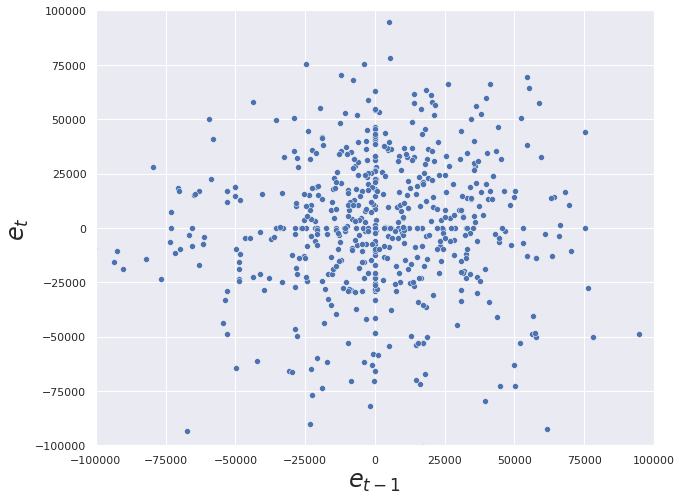

In [ ]:
sns.set()
fig, axes = plt.subplots(1,1, figsize=(10, 8))
sns.scatterplot(vector_Se[:605], vector_Se[1:], ax=axes).set(xlim=(-100000,100000),ylim=(-100000,100000))
axes.set_xlabel('$e_{t-1}$', size=24)
axes.set_ylabel('$e_{t}$', size=24);

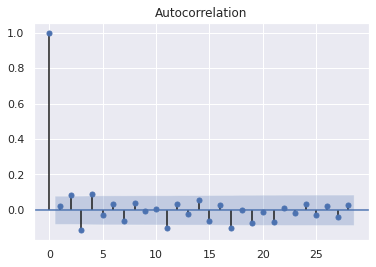

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(vector_Se).show()

### Критерий Дарбина - Уотсона

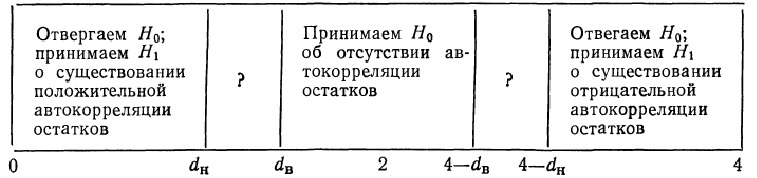

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(result.resid)

1.9399252000245835

### Выбираем значения dl и du при уровне значимости alfa=0.05 и k = 170, n = 606

In [ ]:
alfa = 0.05
dl = 1.832
du = 1.900

a = 0
b = 4

print(f'{a}---{dl}---{du}---{b-du}---{b-dl}---{b}')
print(' cov>0        cov=0        cov<0 \n')
print(f'DW = {durbin_watson(result.resid)}')

0---1.832---1.9---2.1---2.168---4
 cov>0        cov=0        cov<0 

DW = 1.9399252000245835


DW попадает в отрезок (du; b-du) => гипотеза H0 принимается => Автокорреляции остатков нет

### Построим новую модель с использованием робастной ковариационной матрицы

In [ ]:
result_new = result.get_robustcov_results(cov_type = "HC0")

In [ ]:
result.get_robustcov_results(cov_type = "HC0").summary2().tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.615
1,Dependent Variable:,salary_in_usd,AIC:,14750.9964
2,Date:,2022-12-15 12:00,BIC:,15363.5527
3,No. Observations:,606,Log-Likelihood:,-7236.5
4,Df Model:,138,F-statistic:,22.36
5,Df Residuals:,467,Prob (F-statistic):,8.95e-120
6,R-squared:,0.703,Scale:,1.7900e+09


In [ ]:
result.get_robustcov_results(cov_type = "HC0").summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,9.005350e+06,5.904851e+06,1.525077,0.127917,-2.598018e+06,2.060872e+07
work_year,-8.384115e+03,5.527256e+03,-1.516868,0.129977,-1.924549e+04,2.477256e+03
remote_ratio,1.882215e+01,5.034144e+01,0.373890,0.708656,-8.010163e+01,1.177459e+02
experience_level_EN,2.208675e+06,1.473976e+06,1.498447,0.134693,-6.877723e+05,5.105122e+06
experience_level_EX,2.302718e+06,1.477492e+06,1.558532,0.119785,-6.006373e+05,5.206074e+06
...,...,...,...,...,...,...
company_location_US,1.884460e+05,1.241573e+05,1.517801,0.129741,-5.553001e+04,4.324221e+05
company_location_VN,3.696132e+05,1.308516e+05,2.824673,0.004935,1.124823e+05,6.267441e+05
company_size_L,3.006932e+06,1.967060e+06,1.528643,0.127030,-8.584521e+05,6.872316e+06
company_size_M,3.009895e+06,1.970945e+06,1.527133,0.127405,-8.631229e+05,6.882913e+06


In [ ]:
result.get_robustcov_results(cov_type = "HC0").summary2().tables[2]

,0,1,2,3
0,Omnibus:,227.744,Durbin-Watson:,1.940
1,Prob(Omnibus):,0.000,Jarque-Bera (JB):,2014.809
2,Skew:,1.411,Prob(JB):,0.000
3,Kurtosis:,11.475,Condition No.:,3153818922379982336


# Оценка качества модели и её параметров

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
y_hat = model.predict(result_new.params, sm.add_constant(X))
print(f'A_mean = {mean_absolute_percentage_error(Y, y_hat)*100}%')

A_mean = 32.13141035211836%


In [ ]:
R_2 =  0.703
R_adj = 0.615
n = 606
k = 170

A_mean = (1/n) * (sum(abs((result_new.resid) / Y))) * 100
print(f'A_mean = {A_mean}%')

A_mean = 32.131410352118586%


In [ ]:
F_stat = 22.36 # F_набл
F_table = sts.f.isf(0.05, k, n - k - 1)
F_table

1.22781396288184

> F_набл > F_табл (22.36 > 1.2278)  => гипотеза H0 отвергается => модель значима

###**Итоговый вывод по модели. Так как коэффициент детерминации и скорректировннаый коэффициент детерминации равны 0.703 и 0.615 соответсвенно, но при этом средняя относительная ошибка аппроксимации равна 32.131 % > 15% => качество модели низкое.**

### График сравнения предсказанных значений с реальными:

In [ ]:
df['Y_hat'] = y_hat

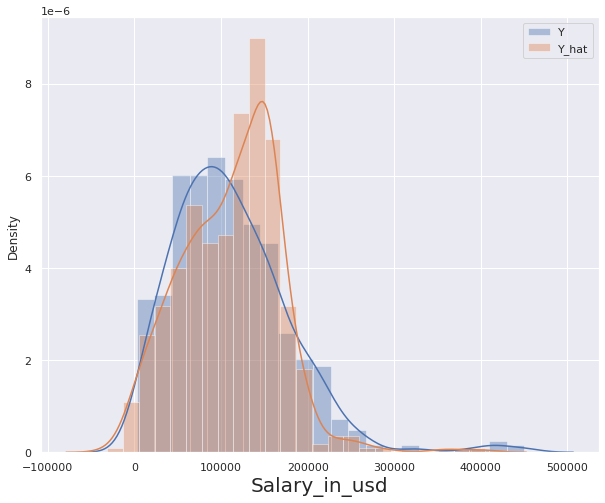

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['salary_in_usd'], ax=ax, label='Y').legend()
sns.distplot(df['Y_hat'], ax=ax, label='Y_hat').legend()
ax.set_xlabel('Salary_in_usd', size=20);

In [ ]:
px.box(df,x='work_year',y='salary_in_usd',color='work_year',labels={'work_year':'year','salary_in_usd':'salary in usd'},template='seaborn',title='<b>Data Science зарплаты по годам')

### Оценка факторов модели:

In [ ]:
job_salaries = df.groupby(['work_year', 'job_title'], as_index=False).agg(mean=('salary_in_usd', 'mean'))
top3_job_salaries= job_salaries[job_salaries['job_title'].isin(["Data Scientist", "Data Engineer", "Data Analyst"])]
top3_job_salaries

,work_year,job_title,mean
5,2020,Data Analyst,45547.285714
6,2020,Data Engineer,88162.000000
10,2020,Data Scientist,85970.523810
34,2021,Data Analyst,79505.411765
38,2021,Data Engineer,83202.531250
43,2021,Data Scientist,70671.733333
72,2022,Data Analyst,100550.739726
77,2022,Data Engineer,126375.696629
80,2022,Data Scientist,136172.090909


In [ ]:
fig = px.line(top3_job_salaries, x="work_year", y="mean", color='job_title', markers=True)
fig.update_xaxes(type="category")
fig.update_traces(marker_size=10)
fig.update_layout(margin=dict(t=35, b=45, l=45, r=20),
                        coloraxis_showscale=False,
                        title_text='Топ 3 наиболее оплачиваемых специальностей по годам',
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#f1deba', paper_bgcolor='#f1deba',
                        title_font=dict(size=25, color='black', family="Lato, sans-serif"),
                        font=dict(color='black'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                          )
fig.show()

In [ ]:
fig=make_subplots(rows=4,cols=1,subplot_titles=('<i>Experience Level', '<i>Remote Ratio', '<i>Company Size', '<i>Year'))
fig.add_trace(go.Box(x=df['experience_level'] ,y=df['salary_in_usd'], boxpoints='all'),row=1,col=1)
fig.add_trace(go.Box(x=df['remote_ratio'] ,y=df['salary_in_usd'], boxpoints='all'),row=2,col=1)
fig.add_trace(go.Box(x=df['company_size'] ,y=df['salary_in_usd'], boxpoints='all'),row=3,col=1)
fig.add_trace(go.Box(x=df['work_year'] ,y=df['salary_in_usd'], boxpoints='all'),row=4,col=1)


fig.update_layout(height=1000, width=800, title_text='<b>Зависимость зарплаты от разных факторов', font_size=20)
fig.update_layout(template='seaborn', title_x=0.5, font_family='Courier New', showlegend=False)

In [ ]:
df['experience_level'] = df['experience_level'].replace('EN','Junior')
df['experience_level'] = df['experience_level'].replace('MI','Intermediate')
df['experience_level'] = df['experience_level'].replace('SE','Expert')
df['experience_level'] = df['experience_level'].replace('EX','Director')

In [ ]:
df['employment_type'] = df['employment_type'].replace('FT','Full-Time')
df['employment_type'] = df['employment_type'].replace('CT','Contract')
df['employment_type'] = df['employment_type'].replace('PT','Part-Time')
df['employment_type'] = df['employment_type'].replace('FL','Freelance')

In [ ]:
mean_exp_salary = (
    df.groupby(['work_year', 'experience_level'], as_index=False)
      .agg(mean=('salary_in_usd', 'mean'))
)

mean_exp_salary

,work_year,experience_level,mean
0,2020,Director,202416.500000
1,2020,Expert,137240.500000
2,2020,Intermediate,85950.062500
3,2020,Junior,63648.600000
4,2021,Director,223752.727273
5,2021,Expert,126596.188406
6,2021,Intermediate,85490.088889
7,2021,Junior,59101.021277
8,2022,Director,178313.846154
9,2022,Expert,143043.398964


In [ ]:
fig = px.bar(mean_exp_salary, x="work_year", y="mean", 
             color="experience_level", barmode = 'group')
fig.update_yaxes(showgrid=False)
fig.update_traces(hovertemplate=None, texttemplate="%{y}", textfont_color='white', marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(margin=dict(t=70, b=90, l=90, r=40),
                        coloraxis_showscale=False,
                        title_text='Уровень зарплаты в зависмости от опыта работы',
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#f1deba', paper_bgcolor='#f1deba',
                        title_font=dict(size=25, color='black', family="Lato, sans-serif"),
                        font=dict(color='black'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                          )
fig.show()

In [ ]:
mean_size_salary = (
    df.groupby(['work_year', 'company_size'], as_index=False)
      .agg(mean=('salary_in_usd', 'mean'))
)


fig = px.bar(mean_size_salary, x="work_year", y="mean", 
             color="company_size", barmode = 'group')
fig.update_yaxes(showgrid=False)
fig.update_traces(hovertemplate=None, texttemplate="%{y}", textfont_color='white', marker=dict(line=dict(color='#000000', width=2)))
fig.update_layout(margin=dict(t=70, b=90, l=90, r=40),
                        coloraxis_showscale=False,
                        title_text='Уровень заработной платы в зависимости от размера компании',
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#f1deba', paper_bgcolor='#f1deba',
                        title_font=dict(size=25, color='black', family="Lato, sans-serif"),
                        font=dict(color='black'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                          )
fig.show()

In [ ]:
result.get_robustcov_results(cov_type = "HC0").summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Ordinary least squares
=======================================================================================================================
Model:                                OLS                               Adj. R-squared:                      0.615     
Dependent Variable:                   salary_in_usd                     AIC:                                 14750.9964
Date:                                 2022-12-15 12:02                  BIC:                                 15363.5527
No. Observations:                     606                               Log-Likelihood:                      -7236.5   
Df Model:                             138                               F-statistic:                         22.36     
Df Residuals:                         467                               Prob (F-statistic):                  8.95e-120 
R-squared:                            0.703                             Scale:                               1.7900e+09
-----------------------------------------------------------------------------------------------------------------------
                                                      Coef.       Std.Err.      t    P>|t|      [0.025        0.975]   
-----------------------------------------------------------------------------------------------------------------------
Intercept                                          9005349.8726 5904851.1834  1.5251 0.1279 -2598017.8712 20608717.6163
work_year                                            -8384.1151    5527.2556 -1.5169 0.1300   -19245.4861     2477.2559
remote_ratio                                            18.8222      50.3414  0.3739 0.7087      -80.1016      117.7459
experience_level_EN                                2208674.7508 1473976.2628  1.4984 0.1347  -687772.2709  5105121.7724
experience_level_EX                                2302718.3016 1477491.9695  1.5585 0.1198  -600637.2832  5206073.8864
experience_level_MI                                2236257.9793 1476742.2185  1.5143 0.1306  -665624.3022  5138140.2608
experience_level_SE                                2257698.8409 1476714.5034  1.5289 0.1270  -644128.9790  5159526.6608
employment_type_CT                                 2331563.4154 1475457.1335  1.5802 0.1147  -567793.6011  5230920.4319
employment_type_FL                                 2212439.8926 1471897.1067  1.5031 0.1335  -679921.4692  5104801.2543
employment_type_FT                                 2234713.0298 1477734.3758  1.5123 0.1311  -669118.8971  5138544.9567
employment_type_PT                                 2226633.5348 1480232.4715  1.5042 0.1332  -682107.2919  5135374.3615
job_title_3D_Computer_Vision_Researcher             136519.9011  112711.1276  1.2112 0.2264   -84963.8623   358003.6645
job_title_AI_Scientist                              180548.3745  120285.0597  1.5010 0.1340   -55818.5953   416915.3444
job_title_Analytics_Engineer                        165558.4226  120647.5868  1.3722 0.1706   -71520.9336   402637.7788
job_title_Applied_Data_Scientist                    250780.0488  126888.2485  1.9764 0.0487     1437.4381   500122.6596
job_title_Applied_Machine_Learning_Scientist        403695.3351  124103.7276  3.2529 0.0012   159824.4661   647566.2041
job_title_BI_Data_Analyst                           133613.3847  115018.9720  1.1617 0.2460   -92405.4239   359632.1933
job_title_Big_Data_Architect                        145554.0696  114924.6501  1.2665 0.2060   -80279.3912   371387.5304
job_title_Big_Data_Engineer                         145746.7838  115931.6584  1.2572 0.2093   -82065.5055   373559.0730
job_title_Business_Data_Analyst                     125931.7722  120822.2971  1.0423 0.2978  -111490.8998   363354.4441
job_title_Cloud_Data_Engineer                       256816.7384  119156.2703  2.1553 0.0316    22667.9037   490965.5731
job_title_Computer_Vision_Engineer 